In [ ]:
###  模块与数据导入

# 模块导入
import os 
import math

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import lightgbm as lgb
import xgboost as xgb
import featuretools as ft
import matplotlib.pyplot as plt

from scipy import stats
from tqdm import trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import utils

# 数据导入
combi = pd.read_csv('Dataset/combi.csv')

# 划分训练集，验证集，测试集
train_data = combi[combi['Time'] < '2021-12-22 08:00:00']
val_data = combi[(combi['Time'] > '2021-12-22 08:00:00') & (combi['Time'] < '2021-12-22 23:30:00')]
pred_data = combi[combi['Time'] >= '2021-12-22 23:30:00']
Train_data = pd.concat([train_data, val_data], axis=0)

# 导出分析报告
# import pandas_profiling
# pfr = pandas_profiling.ProfileReport(combi)
# pfr.to_file("combi.html")

# 'Grate_switch', 'Feed_switch', 'Push_auto_feed','Grate_auto', 
features = ['Fan_speed', '2_air_door',
       '2wind', '1wind', '1_air_door', 'O2', 
       'SO2', 'Manual_feed', 'CO', 'Water_level',
       'Push_auto', 'HCL', 'NOx', 'Grate_run', 'Grate_manual', 'Water_flow',
       ]

In [2]:
### 生成一些新的信息
combi['Water_flow_shift'] = combi['Water_flow'].shift(-276)
combi['Water_flow_mean']  = combi['Water_flow'].rolling(window=552, min_periods=1, center=True).mean().shift(-276)
mul = combi['Steam_flow'].mean()/combi['Water_flow_mean'].mean()

RMSE: 16.41425004821229


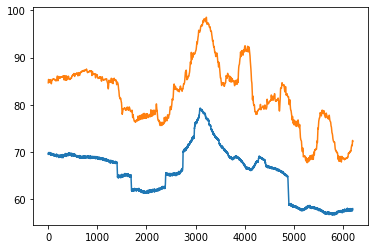

In [3]:
# 总rmse在3.4

aa = combi['Steam_flow'][-8000:-1800]
bb = combi['Water_flow'][-7800:-1600]

plt.plot(np.arange(len(aa)), aa)
plt.plot(np.arange(len(bb)), bb)
print('RMSE:', mean_squared_error(aa, bb, squared=False))

In [4]:
# 基础信息
print('数据类型', combi.info())
print('缺失值统计\n', combi.isnull().sum())
print('总数据量：', combi.shape)
print('训练集大小：', train_data.shape)
print('验证集大小：', val_data.shape)
print('测试集大小：', pred_data.shape)
print('训练集和验证集合并大小：', Train_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259184 entries, 0 to 259183
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Time              259184 non-null  object 
 1   Steam_flow        257384 non-null  float64
 2   Fan_speed         259184 non-null  float64
 3   2_air_door        259184 non-null  float64
 4   Grate_switch      259184 non-null  bool   
 5   2wind             259184 non-null  float64
 6   1wind             259184 non-null  float64
 7   1_air_door        259184 non-null  float64
 8   O2                259184 non-null  float64
 9   Push_auto_feed    259184 non-null  bool   
 10  SO2               259184 non-null  float64
 11  Manual_feed       259184 non-null  float64
 12  CO                259184 non-null  float64
 13  Steam_flow_set    259184 non-null  float64
 14  Water_level       259184 non-null  float64
 15  Push_auto         259184 non-null  float64
 16  HCL               25

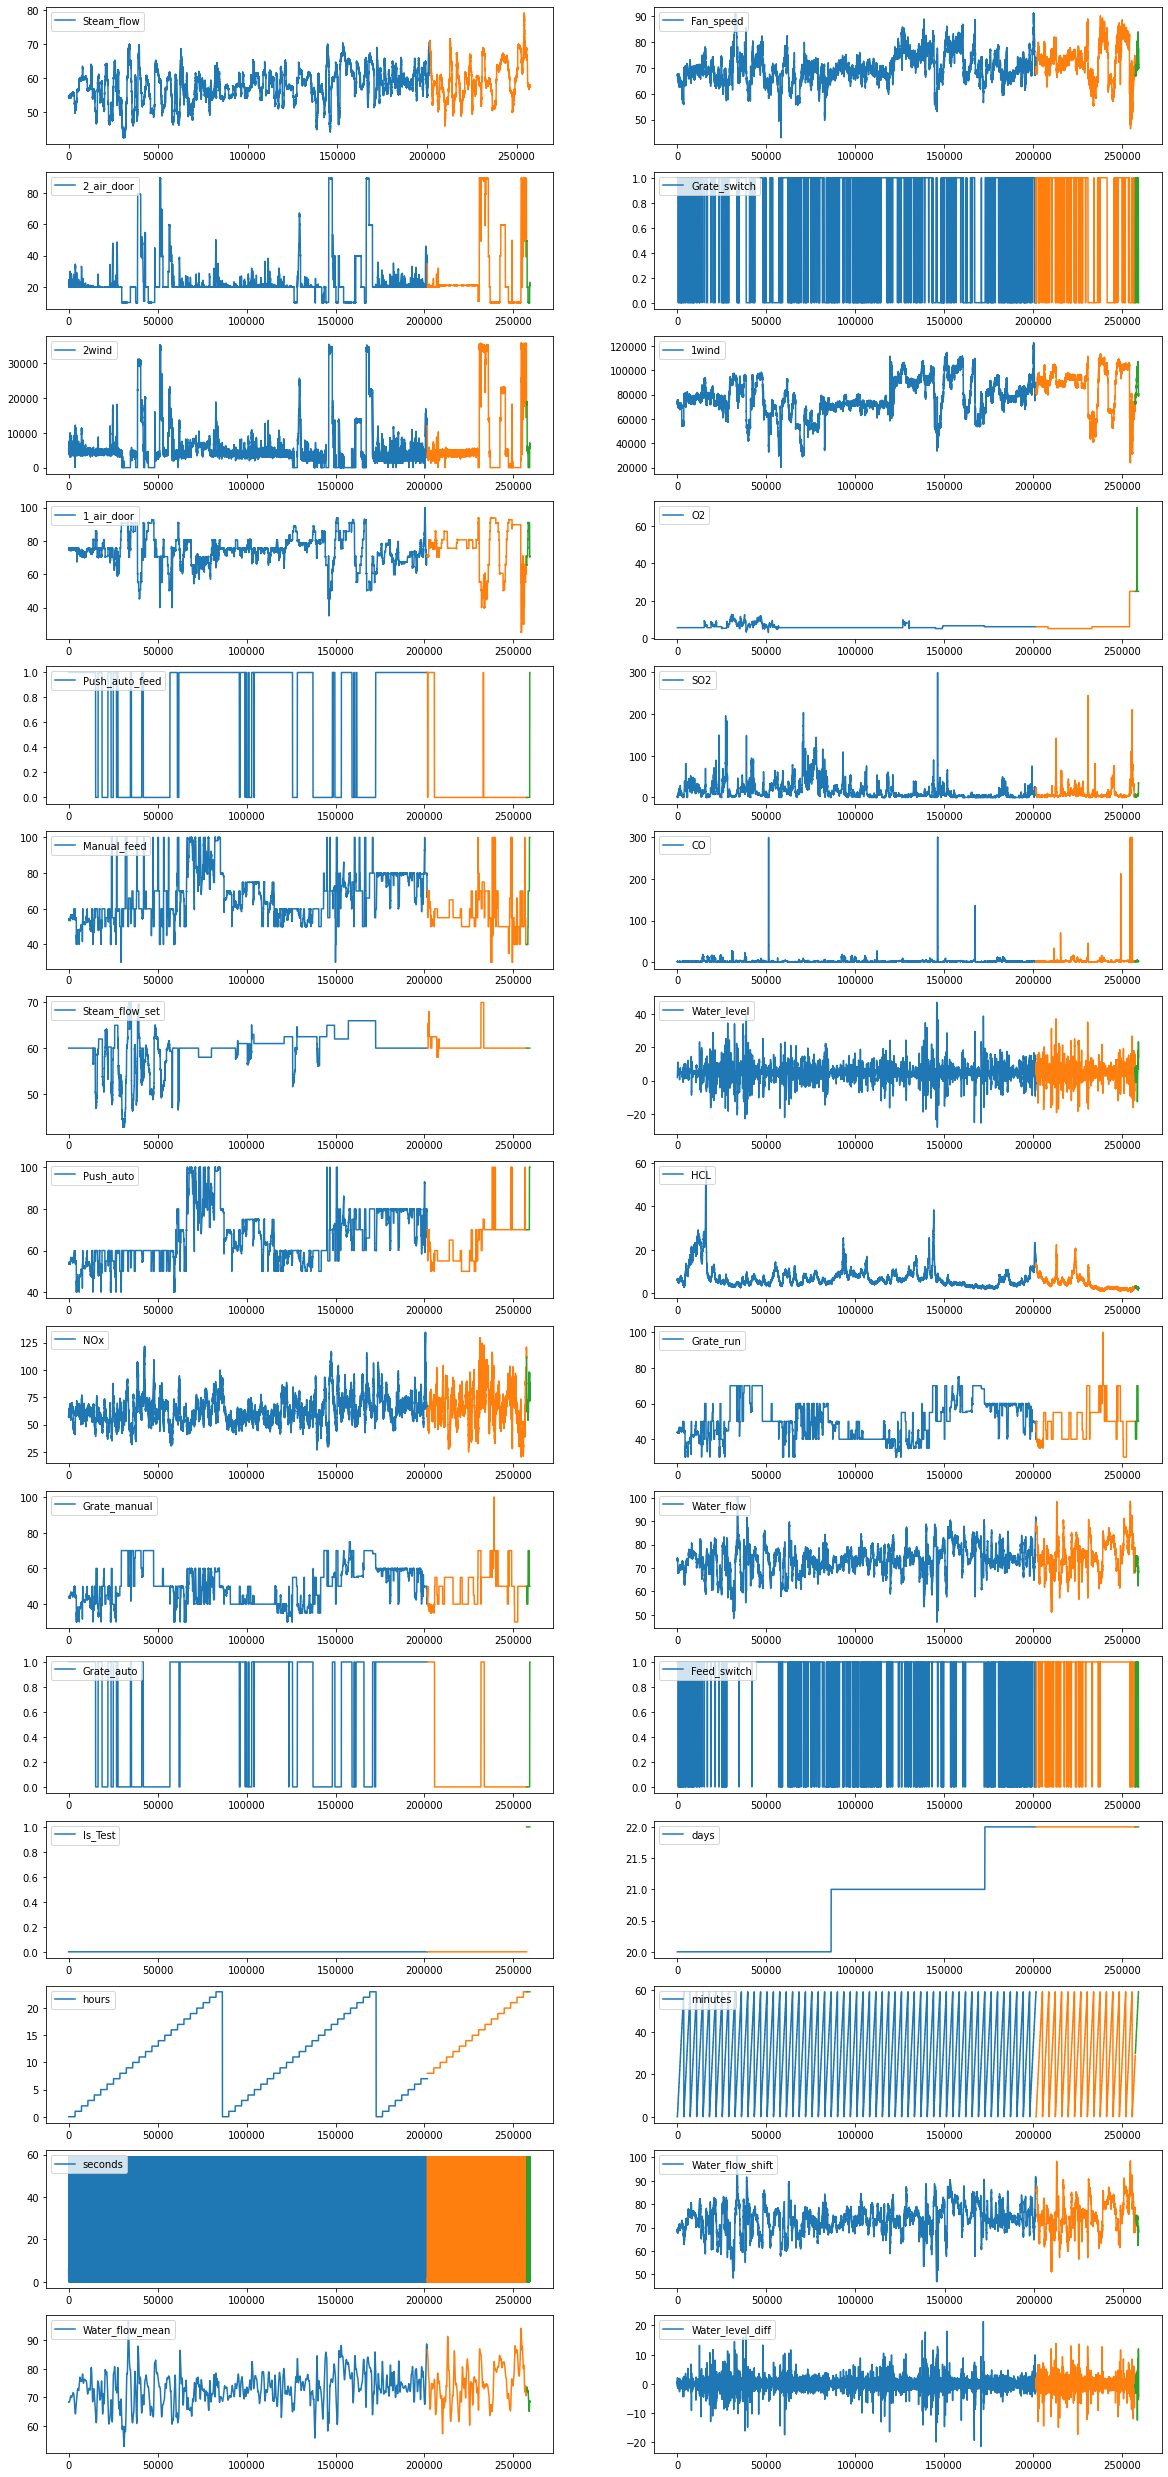

In [5]:
### 绘制总体信息
plt_features = combi.select_dtypes(include=['int64', 'float64', 'bool']).columns
plt.figure(figsize=(20, 3*math.ceil(len(plt_features)/2)))
for i in np.arange(len(plt_features)):
    plt.subplot(math.ceil(len(plt_features)/2), 2, i+1)
    plt.plot(train_data[plt_features[i]], label=plt_features[i])
    plt.plot(val_data[plt_features[i]])
    plt.plot(pred_data[plt_features[i]])
    plt.legend(loc=2)

100%|██████████| 26/26 [1:59:19<00:00, 275.37s/it]  


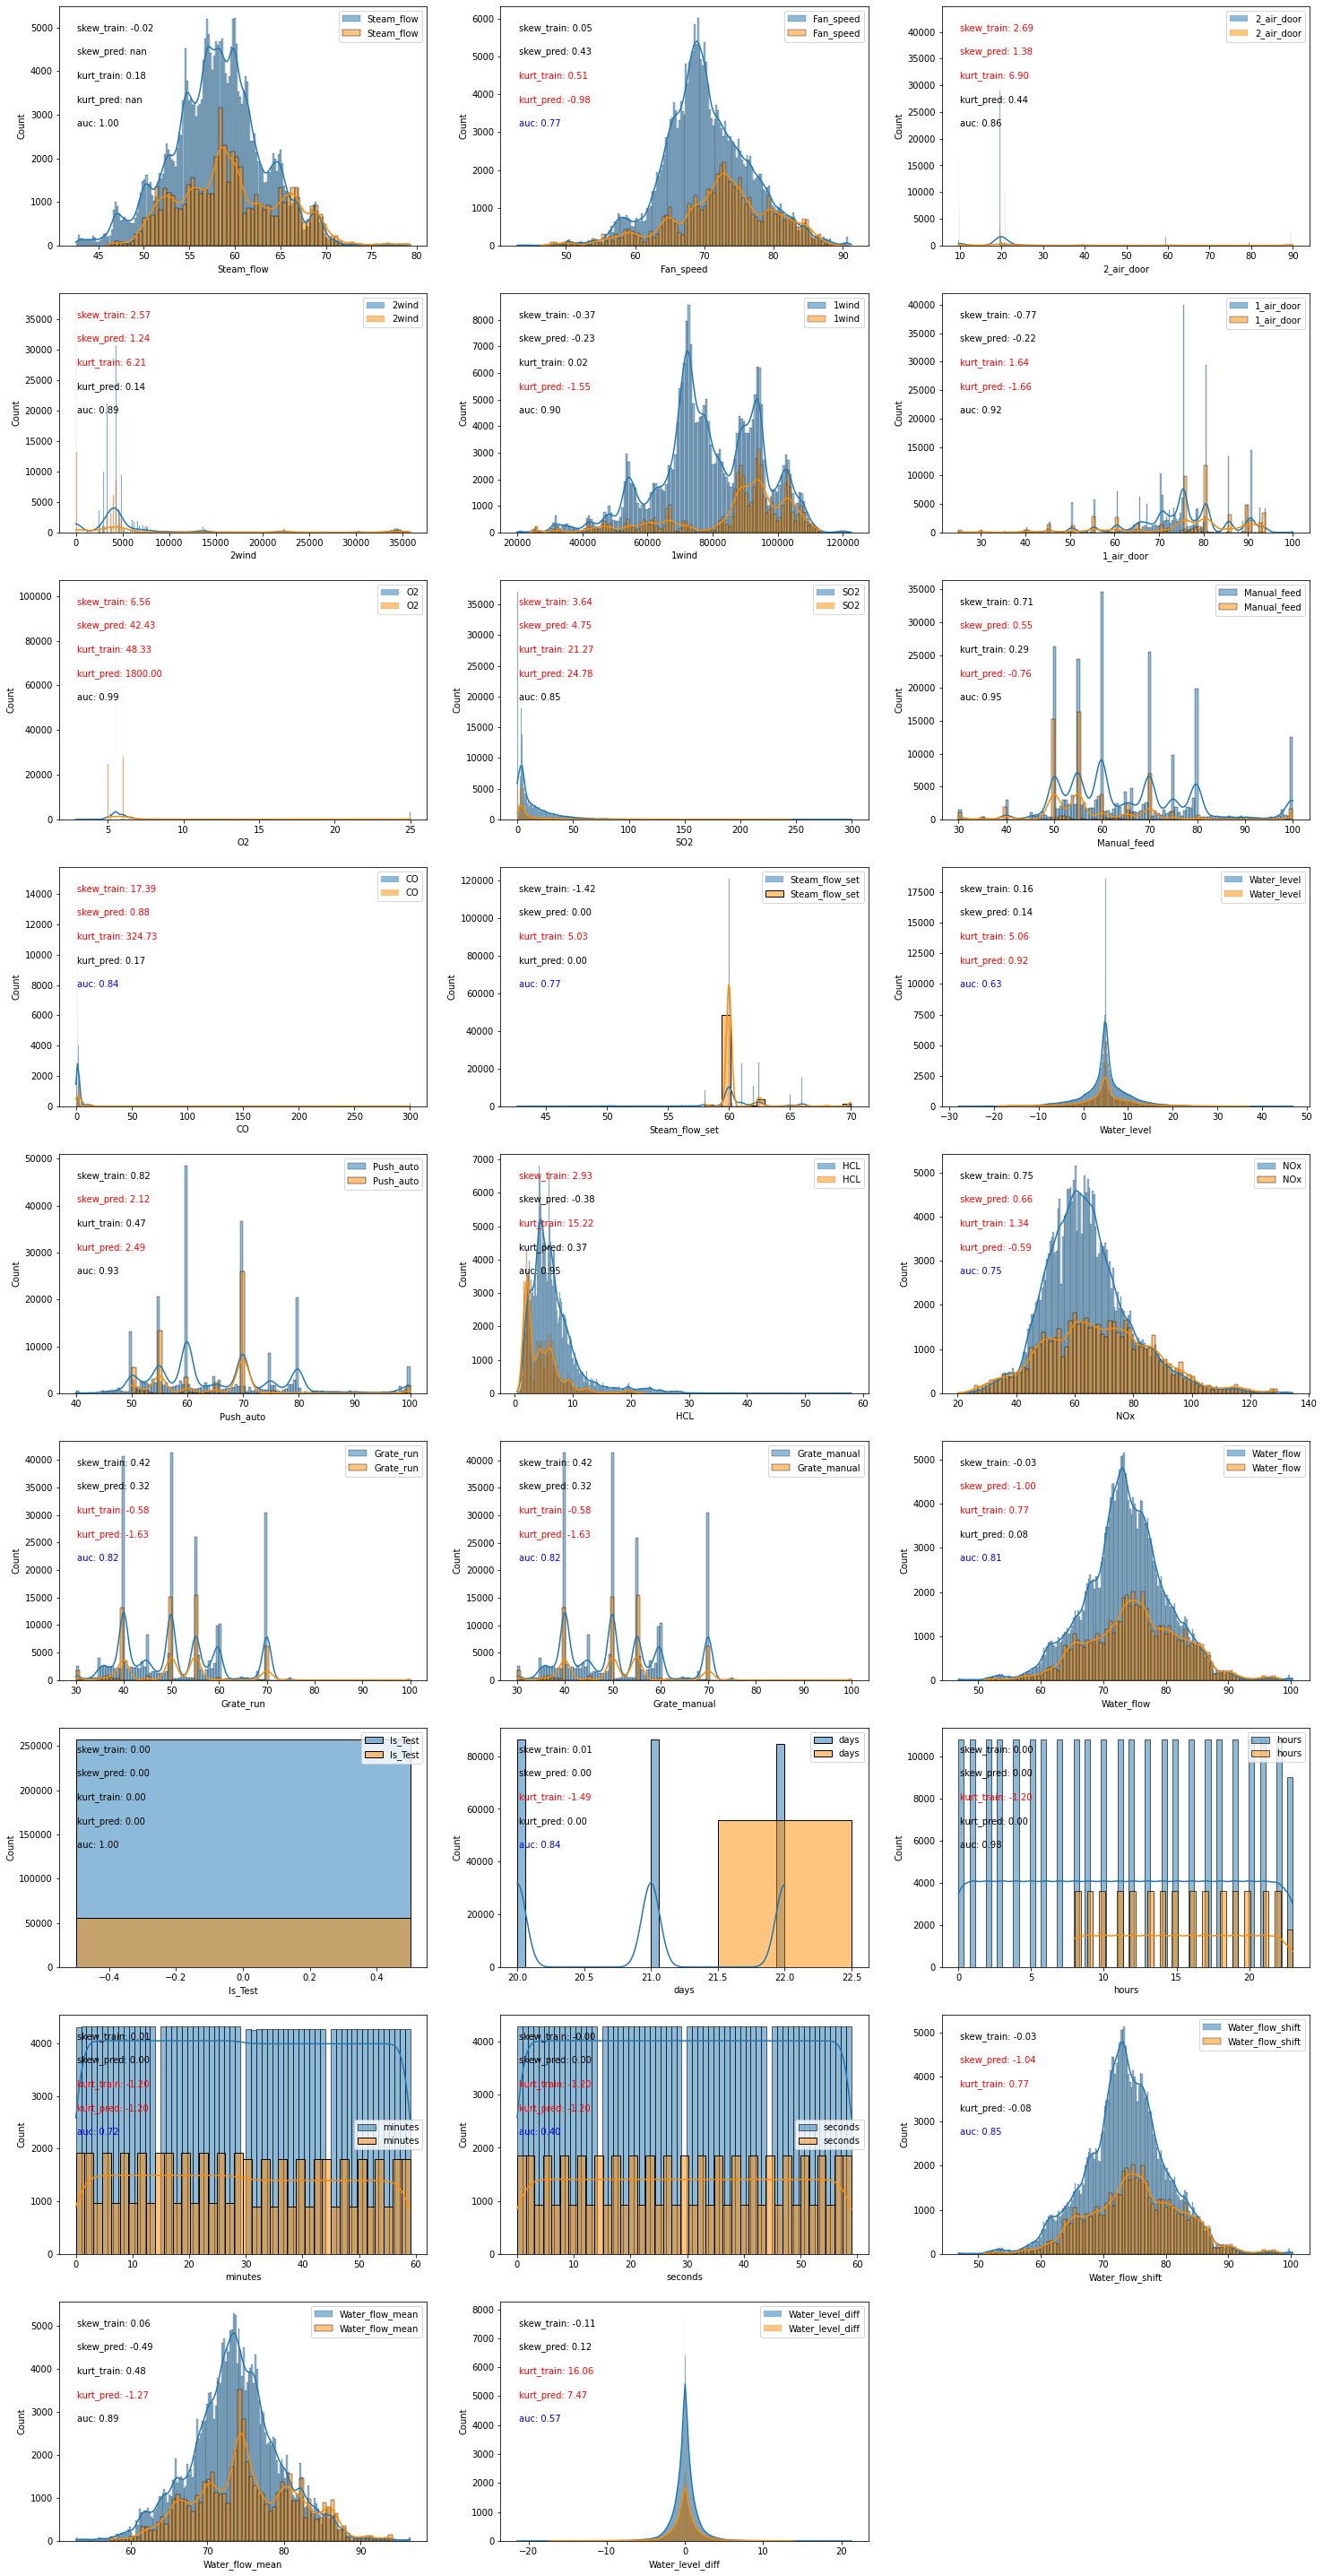

In [6]:
# 查看分布信息, 包含kde, 偏度, 峰度, auc
# 相对有效特征：2wind, SO2, Water_level, NOx, Water_flow
# 分布不同，但可能有效：Fan_speed, HCL

# 定义模型参数(对抗验证模型)
params = {
'boosting_type': 'gbdt',
'objective': 'binary',
'num_leaves': 300,
'learning_rate': 0.1,
'metric': 'auc',
'verbose': -1,
'min_data_in_leaf': 6,
'max_depth':30,
'seed':42, 
'sub_feature': 0.7, 
}


plt_features = combi.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(25, 4*math.ceil(len(plt_features)/2)))
for i in trange(len(plt_features)):
    
    plt.subplot(math.ceil(len(plt_features)/3), 3, i+1)
    sns.histplot(Train_data[plt_features[i]], kde=True, label=plt_features[i], color='#1F77B4')
    # sns.kdeplot(Train_data[plt_features[i]], shade=True, label=plt_features[i], warn_singular=False)
    plt.annotate('skew_train: {:.2f}'.format(Train_data[plt_features[i]].skew()), xy=(0.05, 0.9), xycoords='axes fraction', \
        color='r' if np.abs(Train_data[plt_features[i]].skew()) > 2 else 'k')
    plt.annotate('kurt_train: {:.2f}'.format(Train_data[plt_features[i]].kurt()), xy=(0.05, 0.7), xycoords='axes fraction', \
        color='r' if np.abs(Train_data[plt_features[i]].kurt()) > 0.5 else 'k')
    

    sns.histplot(val_data[plt_features[i]], kde=True, label=plt_features[i], color='#FF8C00')
    # sns.kdeplot(pred_data[plt_features[i]], shade=True, warn_singular=False)
    plt.annotate('skew_pred: {:.2f}'.format(pred_data[plt_features[i]].skew()), xy=(0.05, 0.8), xycoords='axes fraction', \
        color='r' if np.abs(pred_data[plt_features[i]].skew()) > 0.5 else 'k')
    plt.annotate('kurt_pred: {:.2f}'.format(pred_data[plt_features[i]].kurt()), xy=(0.05, 0.6), xycoords='axes fraction', \
        color='r' if np.abs(pred_data[plt_features[i]].kurt()) > 0.5 else 'k')
    
    # adc_val
    adv_data = lgb.Dataset(data=combi[[plt_features[i]]], label=combi.loc[:, 'Is_Test'])
    adv_cv_results = lgb.cv(params, adv_data, num_boost_round=30, nfold=5, seed=42)

    plt.annotate('auc: {:.2f}'.format(adv_cv_results['auc-mean'][-1]), xy=(0.05, 0.5), xycoords='axes fraction', \
        color='b' if np.abs(adv_cv_results['auc-mean'][-1]) < 0.85 else 'k')
    
    plt.legend()

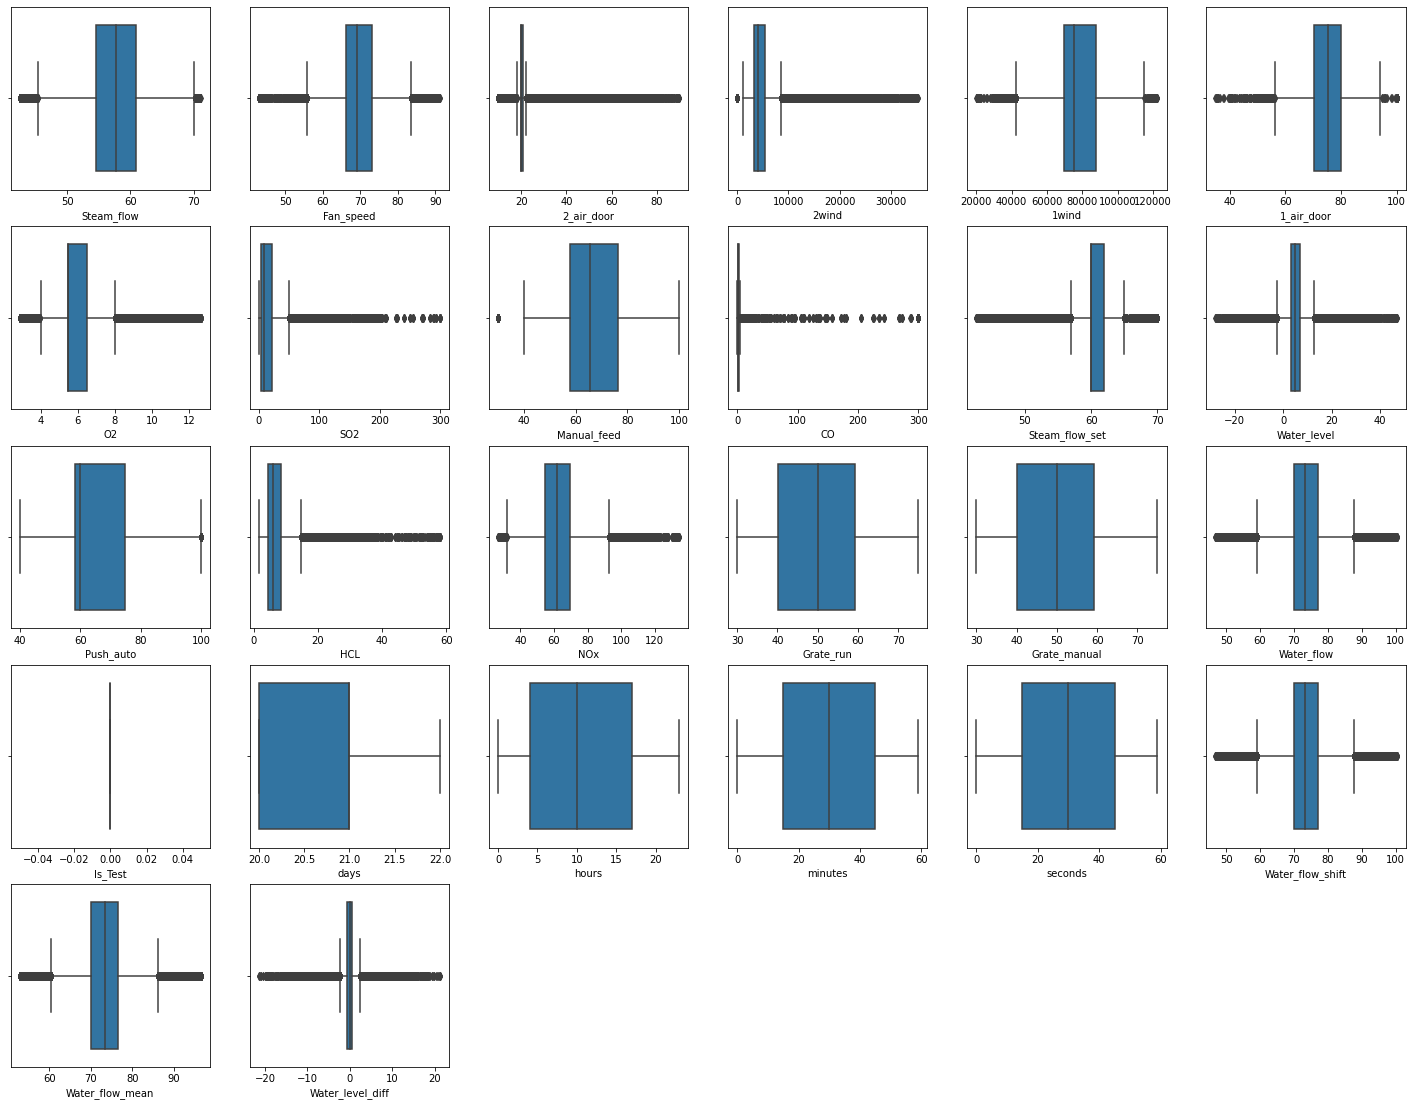

In [7]:
# 查看变量箱型图
plt_features = combi.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(25, 1.5*math.ceil(len(plt_features)/2)))

for i in np.arange(len(plt_features)):
    plt.subplot(math.ceil(len(plt_features)/6), 6, i+1)
    sns.boxplot(x=train_data[plt_features[i]])

ValueError: object arrays are not supported

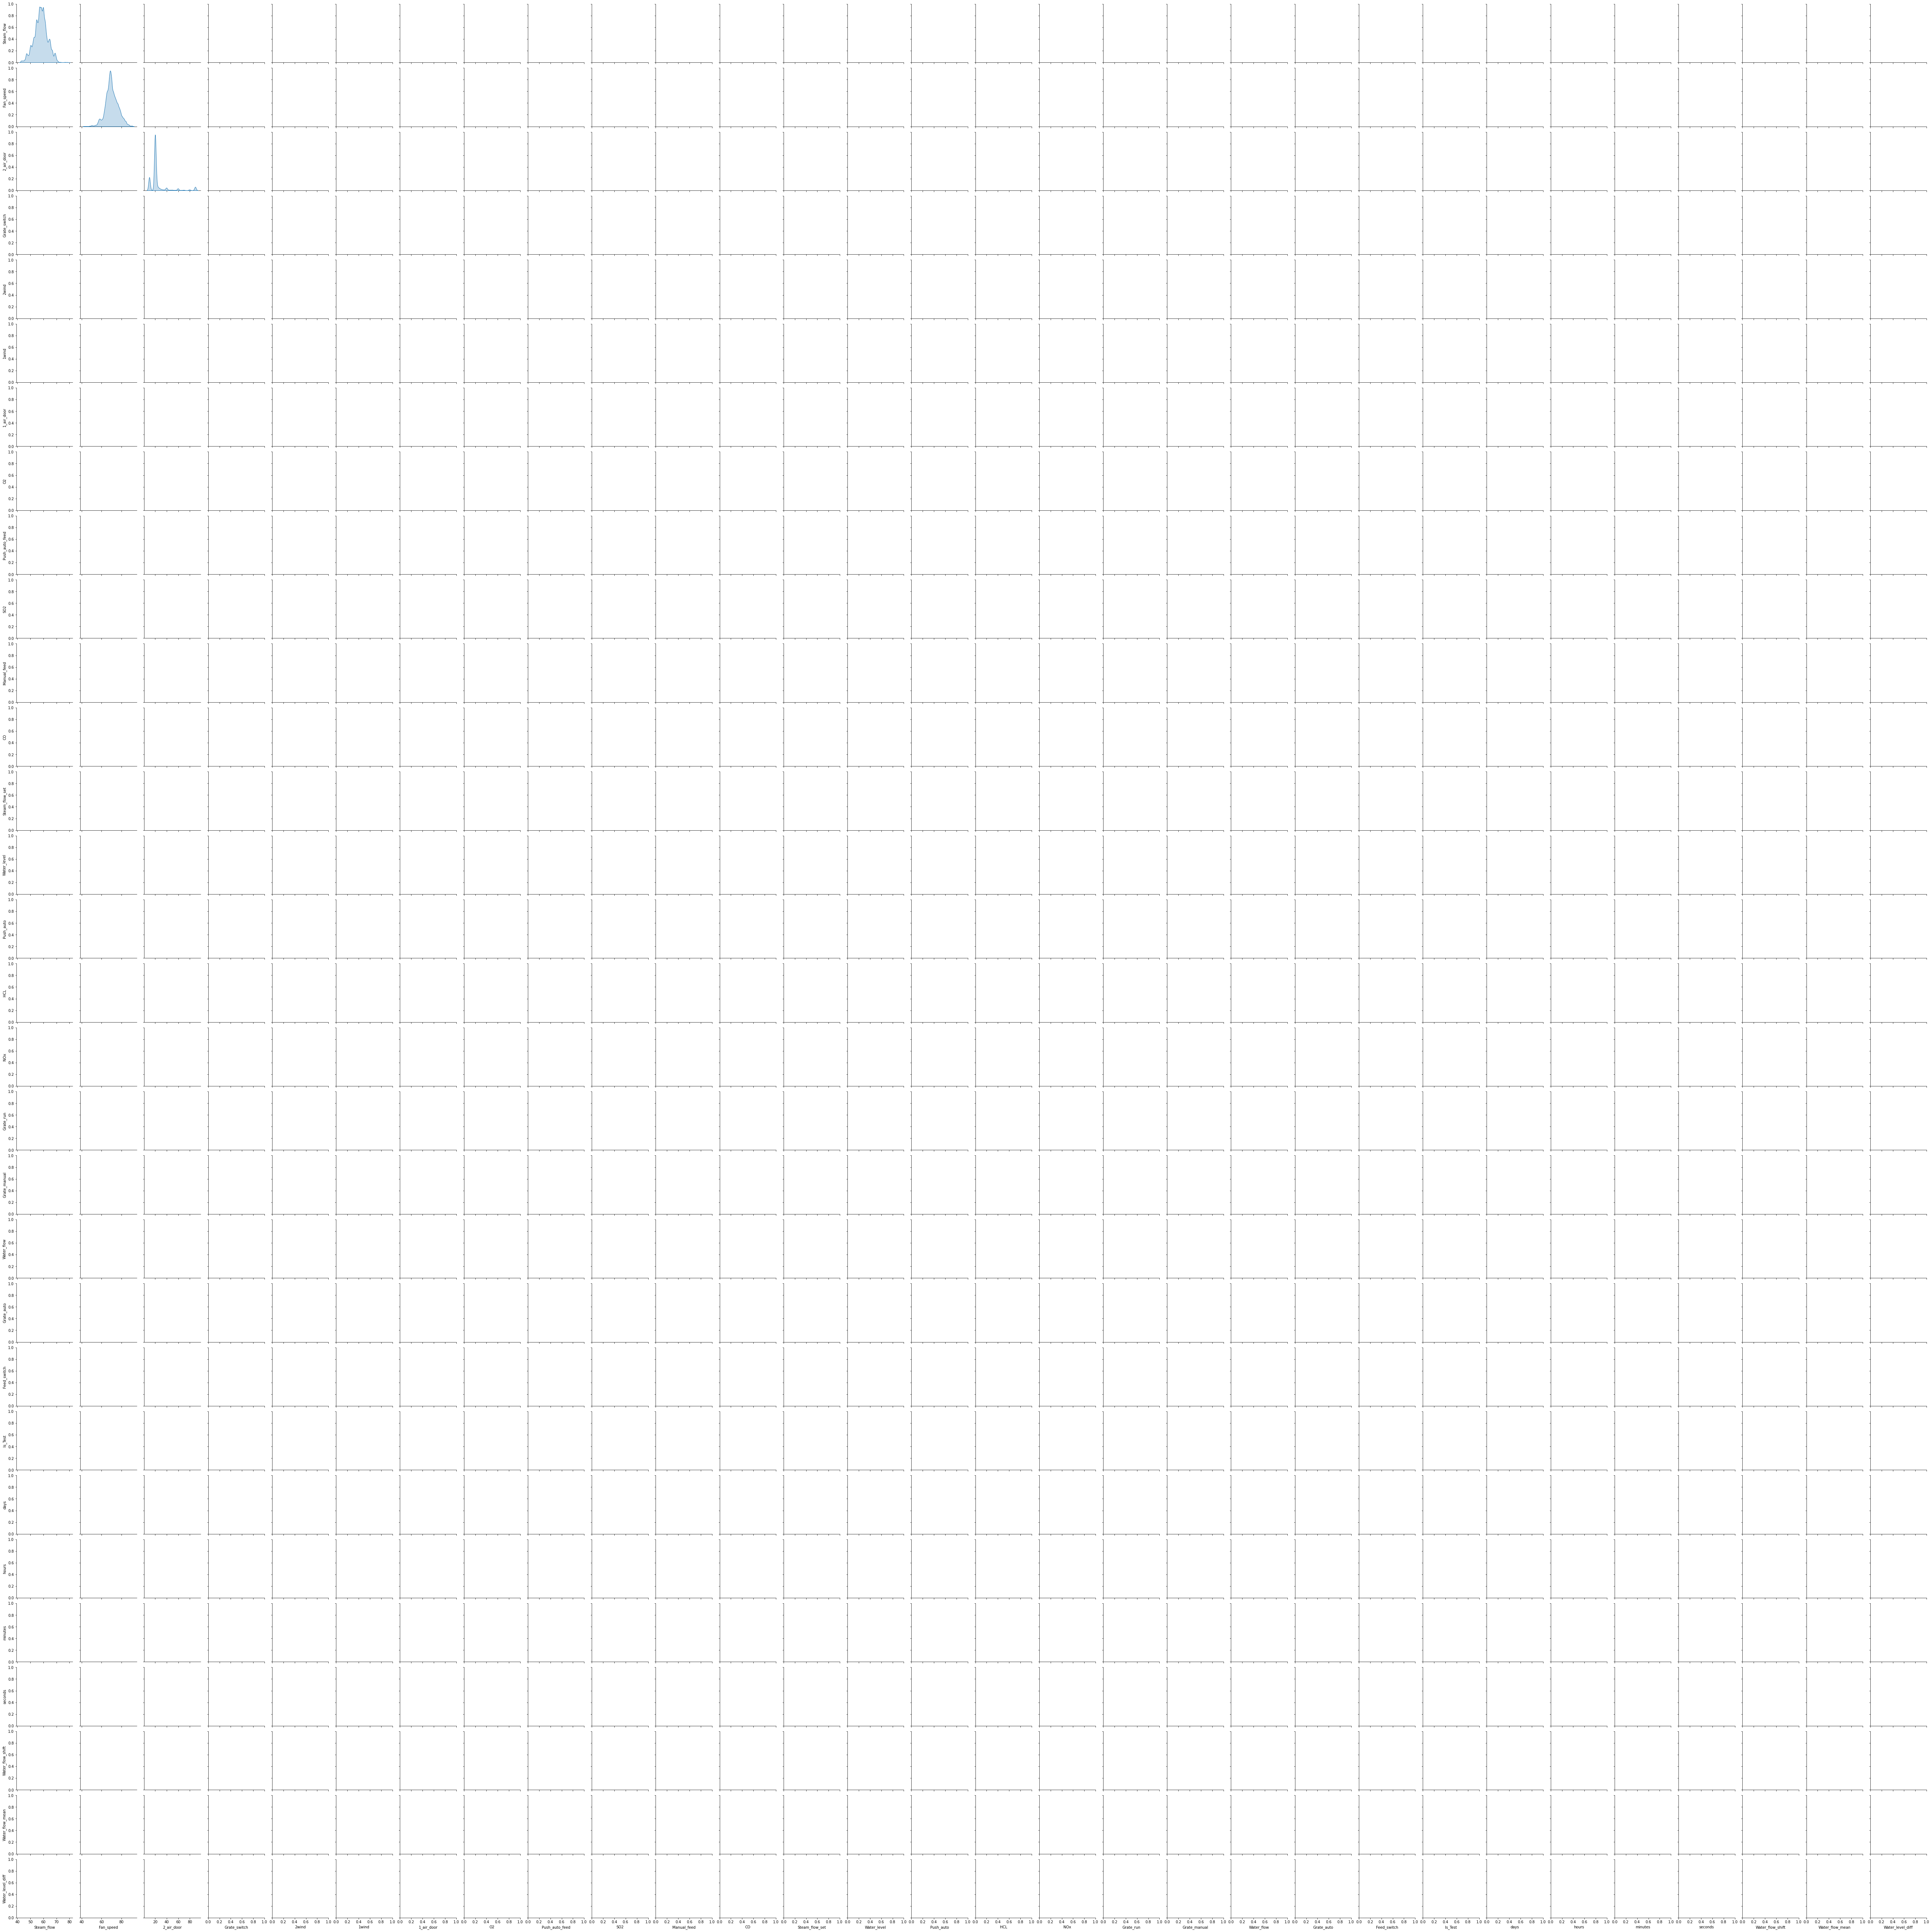

In [8]:
# 特征相关性(报错，晚点修)
# 此处可删除与相近特征的皮尔森相关系数均大于0.75的项
plt_features = combi.select_dtypes(include=['int64', 'float64', 'bool']).columns
sns.pairplot(combi[plt_features], diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})

In [ ]:
# 相关系数热力图
plt.figure(figsize=(16, 16))
sns.heatmap(combi.corr(), vmax=.8, square=True, annot=True)
combi.corr().nlargest(10, 'Steam_flow')['Steam_flow'].index

In [ ]:
# 对抗验证

features = ['Fan_speed', '2_air_door', 'Grate_switch', 'Feed_switch',
       '2wind', '1wind', '1_air_door', 'O2', 'Push_auto_feed', 'Grate_auto', 
       'SO2', 'Manual_feed', 'CO', 'Water_level',
       'Push_auto', 'HCL', 'NOx', 'Grate_run', 'Grate_manual', 'Water_flow',
       ]
    
Train_data = pd.concat([train_data, val_data])
Train_data['Is_Test'] = 0
pred_data['Is_Test'] = 1
df_adv =  pd.concat([Train_data, pred_data])

adv_data = lgb.Dataset(
    data=df_adv[features], label=df_adv.loc[:, 'Is_Test']
)

# 定义模型参数
params = {
'boosting_type': 'gbdt',
'objective': 'binary',
'num_leaves': 40,
'learning_rate': 0.1,
'metric': 'auc',
'verbose': -1,
'min_data_in_leaf': 5,
'max_depth':7,
'seed':42, 
'sub_feature': 0.7, 
}

categorical_columns = ['Grate_auto', 'Feed_switch', 'Grate_switch', 'Push_auto_feed']
adv_cv_results = lgb.cv(
    params, 
    adv_data,
    num_boost_round=30, 
    nfold=5, 
    categorical_feature=categorical_columns, 
    callbacks=[lgb.log_evaluation(period=1, show_stdv=True), lgb.early_stopping(20)],
    seed=42)

print('交叉验证中最优的AUC为 {:.5f}，对应的标准差为{:.5f}.'.format(
    adv_cv_results['auc-mean'][-1], adv_cv_results['auc-stdv'][-1]))

print('模型最优的迭代次数为{}.'.format(len(adv_cv_results['auc-mean'])))

# 使用训练好的模型，对所有的样本进行预测，得到各个样本属于测试集的概率
params['n_estimators'] = len(adv_cv_results['auc-mean'])

model_adv = lgb.LGBMClassifier(**params)
model_adv.fit(df_adv[features], df_adv.loc[:, 'Is_Test'], \
    categorical_feature=['Grate_auto', 'Feed_switch', 'Grate_switch', 'Push_auto_feed'], 
    callbacks=[lgb.log_evaluation(period=10, show_stdv=True), lgb.early_stopping(200)])

preds_adv = model_adv.predict_proba(df_adv[features])[:, 1]
